## Loading Data

In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset.dataset import ForexDataset
from utils import get_sequence_start_indices

In [25]:
# === CONFIG ===
CHECKPOINT_PATH = r'..\lightning_logs\transformer_3barrier_clas\version_0\checkpoints\best_checkpoint.ckpt'

DATA_PATH = "../data/processed/usdjpy-h1-bar-2019-01-01-2025-05-12_processed.pkl"
FEATURES_COLS = ['close_log_return_scaled', 'log_volume_scaled','ret_mean_5', 'ret_mean_10', 'rsi', 'macd_diff']
SEQUENCE_LENGTH = 30
TARGET_COLS = ['train_label']
HORIZON = 1
STRIDE = 1

In [21]:
df = pd.read_pickle(DATA_PATH)
df = df[df['timestamp'].dt.year > 2024]

IDs = get_sequence_start_indices(
    df,
    sequence_length=SEQUENCE_LENGTH,
    horizon=HORIZON,
    stride=STRIDE,
    group_col='time_group',
)

test_dataset = ForexDataset(
    df, IDs, SEQUENCE_LENGTH, HORIZON, FEATURES_COLS, TARGET_COLS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False
)

                timestamp     open     high      low    close      volume  \
37508 2025-01-07 04:00:00  158.122  158.153  158.017  158.080  13750.6797   
37509 2025-01-07 05:00:00  158.081  158.153  157.783  157.862  18016.5605   
37510 2025-01-07 06:00:00  157.860  157.860  157.678  157.754  18917.8496   
37511 2025-01-07 07:00:00  157.754  157.791  157.454  157.492  26081.0000   
37512 2025-01-07 08:00:00  157.495  157.599  157.397  157.425  18820.0098   
37513 2025-01-07 09:00:00  157.427  157.679  157.362  157.604   9888.7197   
37514 2025-01-07 10:00:00  157.603  157.781  157.560  157.744  19598.7305   
37515 2025-01-07 11:00:00  157.744  157.848  157.620  157.711  15495.0303   
37516 2025-01-07 12:00:00  157.710  157.846  157.682  157.740  14286.5400   
37517 2025-01-07 13:00:00  157.739  157.778  157.579  157.667  14834.9502   
37518 2025-01-07 14:00:00  157.666  157.833  157.533  157.741  23779.4004   
37519 2025-01-07 15:00:00  157.772  158.423  157.772  157.939  60772.6094   

In [22]:
idx = IDs[0]
idx

37508

In [23]:
df.loc[idx:idx+SEQUENCE_LENGTH-1]

,timestamp,open,high,low,close,volume,time,log_volume,log_volume_scaled,time_group,...,ma_21,ret_mean_5,ret_mean_10,label,train_label,macd,macd_signal,macd_diff,rsi,log_dist_from_ma
37508,2025-01-07 04:00:00,158.122,158.153,158.017,158.080,13750.6797,2025-01-07 04:00:00,9.528916,0.566275,321,...,157.628857,0.000434,0.000345,0,1,0.153906,0.071502,0.082404,75.902823,0.002858
37509,2025-01-07 05:00:00,158.081,158.153,157.783,157.862,18016.5605,2025-01-07 05:00:00,9.799102,0.841844,321,...,157.638286,-0.000303,0.000202,0,1,0.139839,0.085169,0.054670,61.000000,0.001418
37510,2025-01-07 06:00:00,157.860,157.860,157.678,157.754,18917.8496,2025-01-07 06:00:00,9.847914,0.891628,321,...,157.639095,-0.000706,0.000083,0,1,0.118608,0.091857,0.026751,56.633292,0.000729
37511,2025-01-07 07:00:00,157.754,157.791,157.454,157.492,26081.0000,2025-01-07 07:00:00,10.169001,1.219112,321,...,157.619524,-0.000996,-0.000020,1,2,0.079722,0.089430,-0.009707,49.589041,-0.000809
37512,2025-01-07 08:00:00,157.495,157.599,157.397,157.425,18820.0098,2025-01-07 08:00:00,9.842729,0.886340,321,...,157.630381,-0.000884,-0.000100,1,2,0.043003,0.080145,-0.037141,47.049356,-0.001304
37513,2025-01-07 09:00:00,157.427,157.679,157.362,157.604,9888.7197,2025-01-07 09:00:00,9.199251,0.230042,321,...,157.669476,-0.000603,-0.000084,1,2,0.028024,0.069721,-0.041697,51.474926,-0.000415
37514,2025-01-07 10:00:00,157.603,157.781,157.560,157.744,19598.7305,2025-01-07 10:00:00,9.883271,0.927690,321,...,157.723333,-0.000150,-0.000226,0,1,0.027137,0.061204,-0.034067,52.887828,0.000131
37515,2025-01-07 11:00:00,157.744,157.848,157.620,157.711,15495.0303,2025-01-07 11:00:00,9.648339,0.688077,321,...,157.743333,-0.000055,-0.000380,1,2,0.023500,0.053663,-0.030163,54.635108,-0.000205
37516,2025-01-07 12:00:00,157.710,157.846,157.682,157.740,14286.5400,2025-01-07 12:00:00,9.567143,0.605263,321,...,157.753238,0.000315,-0.000340,0,1,0.022696,0.047470,-0.024774,53.953954,-0.000084
37517,2025-01-07 13:00:00,157.739,157.778,157.579,157.667,14834.9502,2025-01-07 13:00:00,9.604809,0.643679,321,...,157.759190,0.000307,-0.000288,1,2,0.015984,0.041172,-0.025188,48.173278,-0.000585


In [24]:
df.loc[idx+SEQUENCE_LENGTH+HORIZON-1]

timestamp                  2025-01-08 10:00:00
open                                   158.163
high                                   158.347
low                                    158.148
close                                  158.324
volume                              20611.1406
time                       2025-01-08 10:00:00
log_volume                            9.933636
log_volume_scaled                     0.979058
time_group                                 321
close_delta                              0.163
close_return                          0.001031
close_log_return                       0.00103
close_log_return_scaled               0.887518
ma_21                               158.031714
ret_mean_5                            0.000193
ret_mean_10                           0.000099
label                                        0
train_label                                  1
macd                                      0.12
macd_signal                           0.108033
macd_diff    

## Loading Model

In [28]:
import torch
from models.gru_model import GRUModule
from models.transformer_model import TransformerModule

In [29]:
model = TransformerModule.load_from_checkpoint(CHECKPOINT_PATH)
model.to('cpu')

TransformerModule(
  (model): TransformerModel(
    (input_proj): Linear(in_features=6, out_features=128, bias=True)
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
    )
    (fc_out): Linear(in_features=1

## Plotting Predictions

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [32]:
def plot_class_predictions(y_pred, y_true):
    plt.figure(figsize=(12, 4))
    plt.scatter(range(len(y_pred)), y_pred, label="Predicted")
    plt.scatter(range(len(y_true)), y_true, label="Ground Truth")
    plt.title("Classification Predictions vs Ground Truth")
    plt.xlabel("Sample Index")
    plt.ylabel("Class")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

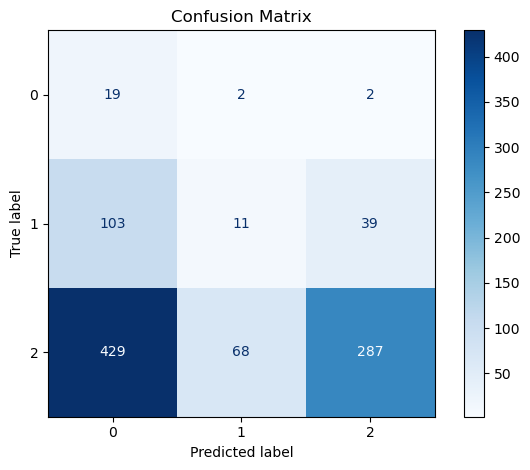

In [33]:
y_pred = []
y_true = []
for x, y, _ in (iter(test_loader)):
    with torch.no_grad():
        _, probs = model(x)
        pred_classes = torch.argmax(probs, dim=1)
        y_pred.extend(pred_classes)
        y_true.extend(y)
plot_confusion_matrix(y_pred, y_true)

In [34]:
y_true

[tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([2.]),
 tensor([2.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([1.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0.]),
 tensor([0

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y, pred_classes, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.83      0.03      0.07       551
           1       0.07      0.14      0.09        81
           2       0.37      0.88      0.52       328

    accuracy                           0.33       960
   macro avg       0.42      0.35      0.23       960
weighted avg       0.61      0.33      0.22       960

